In [1]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override() 
import pandas as pd
import pendulum
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
stock = yf.Ticker('^SSMI')
stock.info

{'exchange': 'EBS',
 'shortName': 'SMI PR',
 'exchangeTimezoneName': 'Europe/Zurich',
 'exchangeTimezoneShortName': 'CET',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '3600000',
 'quoteType': 'INDEX',
 'symbol': '^SSMI',
 'messageBoardId': 'finmb_INDEXSSMI',
 'market': 'ch_market',
 'previousClose': 12075.27,
 'regularMarketOpen': 12100.17,
 'twoHundredDayAverage': 12124.931,
 'trailingAnnualDividendYield': None,
 'payoutRatio': None,
 'volume24Hr': None,
 'regularMarketDayHigh': 12157.62,
 'navPrice': None,
 'averageDailyVolume10Day': 47806030,
 'totalAssets': None,
 'regularMarketPreviousClose': 12075.27,
 'fiftyDayAverage': 12479.346,
 'trailingAnnualDividendRate': None,
 'open': 12100.17,
 'toCurrency': None,
 'averageVolume10days': 47806030,
 'expireDate': None,
 'yield': None,
 'algorithm': None,
 'dividendRate': None,
 'exDividendDate': None,
 'beta': None,
 'circulatingSupply': None,
 'startDate': None,
 'regularMarketDayLow': 11981.06,
 'priceHint': 2,
 'currency': 'CH

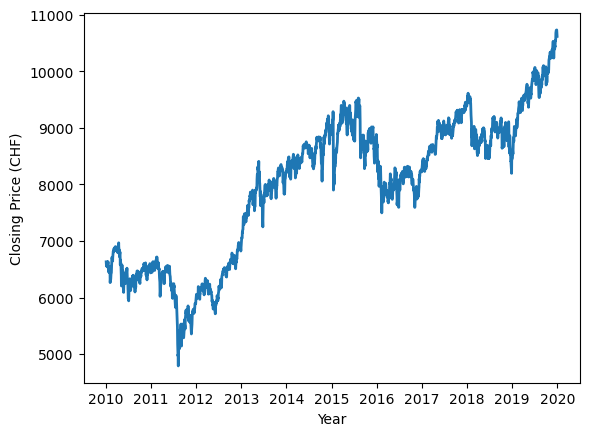

In [3]:
price_history = stock.history(start="2010-01-01", end="2019-12-31",
                                   interval='1d', # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                                   actions=False)
time_series = list(price_history['Close'])
dt_list = [pendulum.parse(str(dt)).date()  for dt in list(price_history.index)]
plt.style.use('default')
plt.ylabel("Closing Price (CHF)")
plt.xlabel("Year")
plt.plot(dt_list, time_series, linewidth=2)
plt.show()

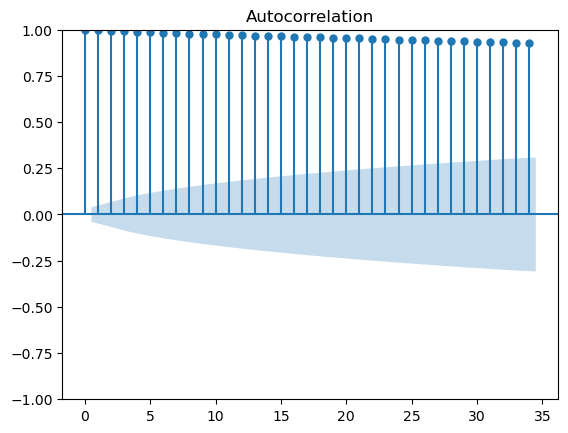

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
# create acf plot
plot_acf(pd.DataFrame(time_series))
plt.show()

### Training the Prophet Model

In [5]:
from pandas import to_datetime

data = pd.DataFrame()
data["ds"], data["y"] = dt_list, time_series
data["ds"] = to_datetime(data["ds"])
data.head()

,ds,y
0,2010-01-04,6631.439941
1,2010-01-05,6579.259766
2,2010-01-06,6559.410156
3,2010-01-07,6555.359863
4,2010-01-08,6617.879883


In [6]:
import fbprophet
print('Prophet %s' % fbprophet.__version__)

Importing plotly failed. Interactive plots will not work.


Prophet 0.7.1


In [7]:
model = fbprophet.Prophet()
model.fit(data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.6381
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7513.23    0.00869181       1133.34           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7729.78    0.00156025        592.26           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7791.11    0.00751676       1102.77          10           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7822.18    0.00212387       293.496      0.2957      0.2957      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7832.66     0.0011424       385.228           1           1      558   
    Iter      log prob        ||dx||      ||grad||       alpha  

  7842.57    0.00795251       750.109           1           1      681   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       7847.93    0.00539735       586.246           1           1      793   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     791       7854.81    0.00013173        380.98   5.259e-07       0.001      955  LS failed, Hessian reset 
     799       7855.95   0.000154739       217.994           1           1      964   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     899       7860.34     0.0019306       106.055           1           1     1078   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     942       7861.36   1.78908e-05       124.195    9.38e-08       0.001     1164  LS failed, Hessian reset 
     973       7861.66    7.8444e-05       218.968   1.116e-06       0.001 

### In-Sample Forecast

          ds         yhat   yhat_lower   yhat_upper
0 2019-01-01  9466.028526  9154.599275  9797.168174
1 2019-02-01  9374.443961  9077.864855  9693.290991
2 2019-03-01  9554.551854  9248.533324  9902.673048
3 2019-04-01  9567.934217  9240.994941  9902.549175
4 2019-05-01  9658.624365  9318.746236  9995.016747


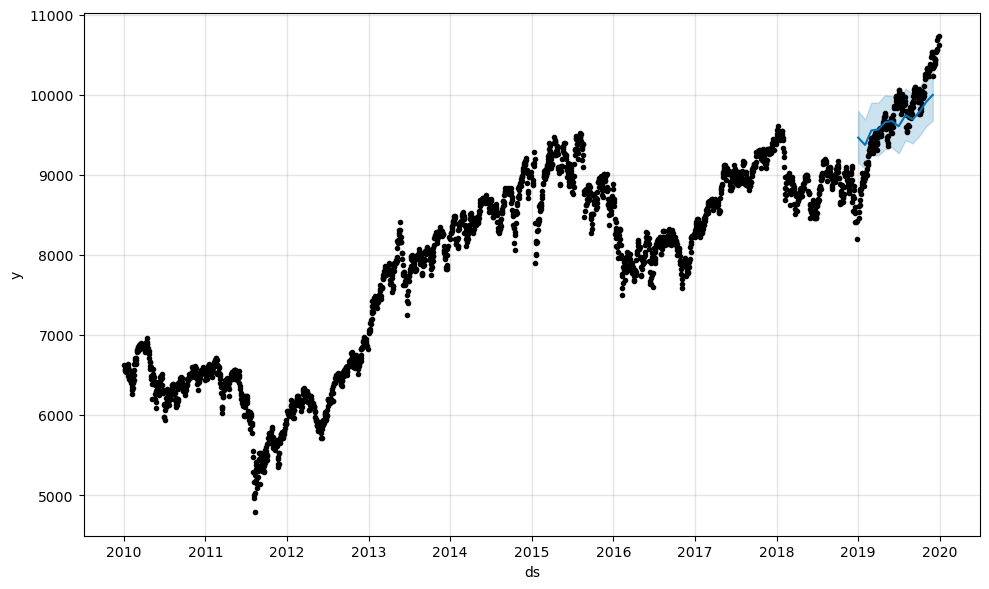

In [8]:
future = list()
for i in range(1, 13):
    date = '2019-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.show()

### Out-of-Sample Prediction

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.6381
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7513.23    0.00869181       1133.34           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7729.78    0.00156025        592.26           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7791.11    0.00751676       1102.77          10           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7822.18    0.00212387       293.496      0.2957      0.2957      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       7832.66     0.0011424       385.228           1           1      558   
    Iter      log prob        ||dx||      ||grad||       alpha  

NameError: name 'pyplot' is not defined

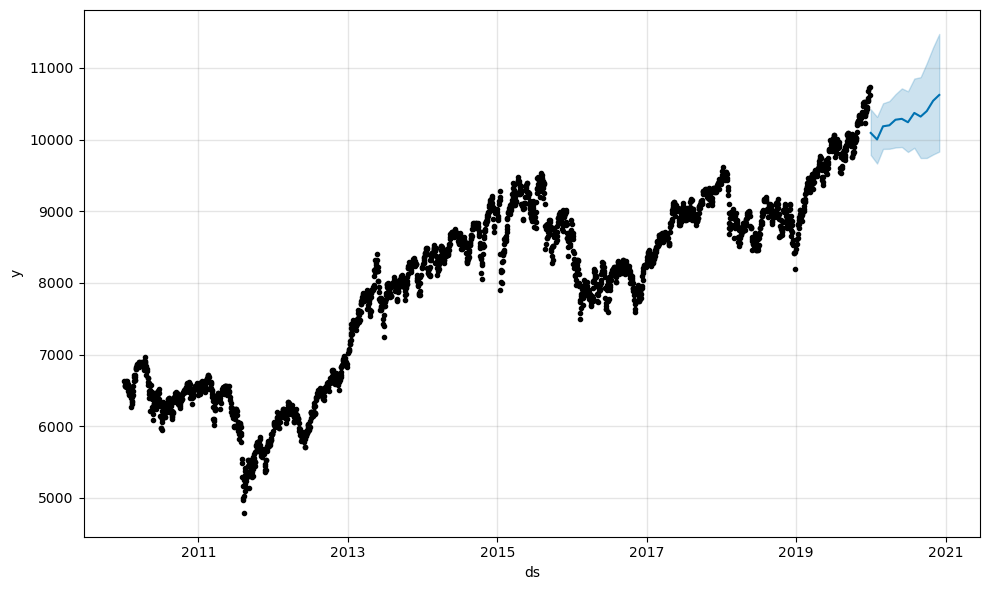

In [10]:
model = fbprophet.Prophet()
# fit the model
model.fit(data)
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2020-%02d' % i
    future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
# use the model to make a forecast
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

### Model Evaluation

MAE: 259.262


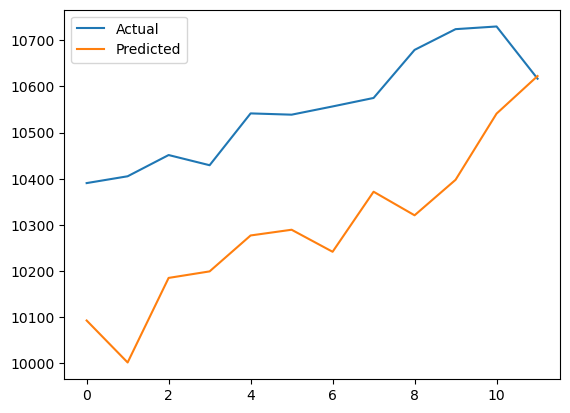

In [14]:
from sklearn.metrics import mean_absolute_error
y_true = data['y'][-12:].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()